# ECOSTRESS SATM Demonstration

Author : Quentin Dehaene, partly based off Caroline Baumann

This demonstration will be focused on displaying a typical usecase for ECOSTRESS images: the selection of the usable images for a time series of LST over Los Angeles.

### First steps : import and display

In [2]:
# Import cell
import rasterio
import rioxarray as rxr
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from datetime import datetime,timedelta
from matplotlib.colors import ListedColormap
import rioxarray.merge as rxr_merge
import matplotlib.animation as animation
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re


Defining directories

In [1]:
LST_folder = 'LA_2023_07_08/LST'
QC_folder = 'LA_2023_07_08/QC'
cloud_mask_folder = 'LA_2023_07_08/cloud_mask'
water_mask_folder ='LA_2023_07_08/water_mask'
LST_masked_folder = 'LA_2023_07_08/LST_masked'

Dsiplay the granules in the LST directory :

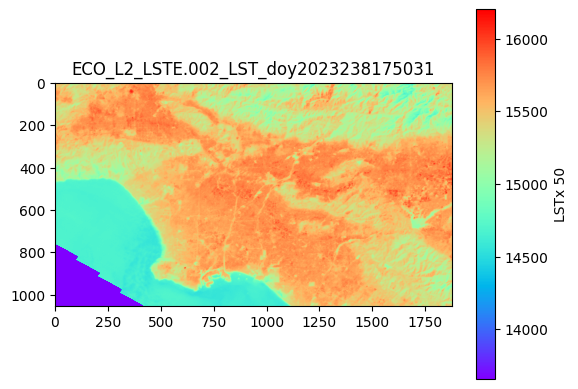

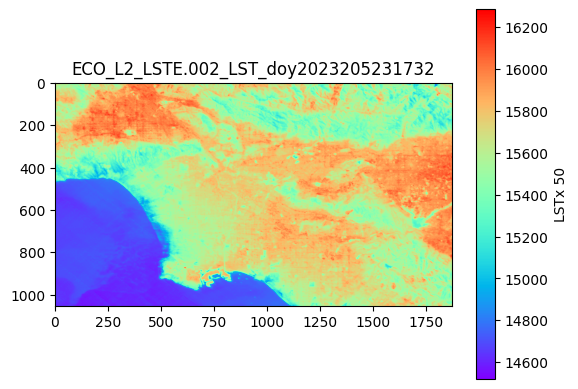

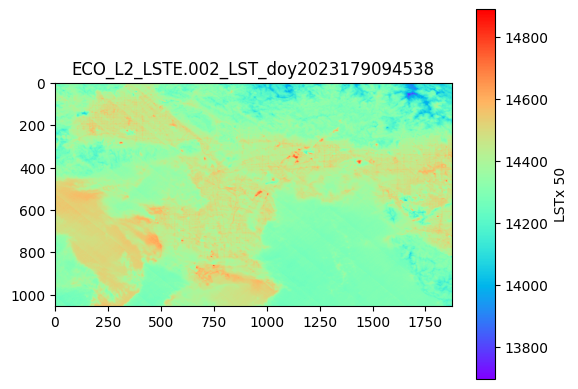

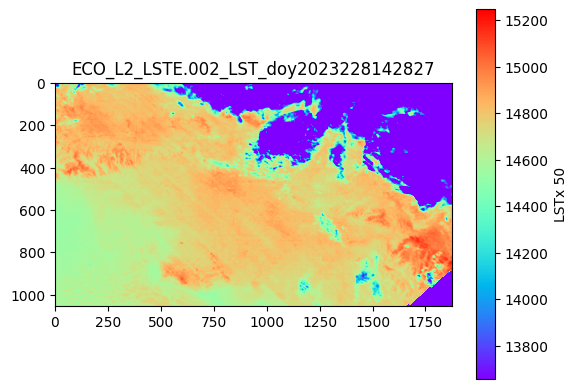

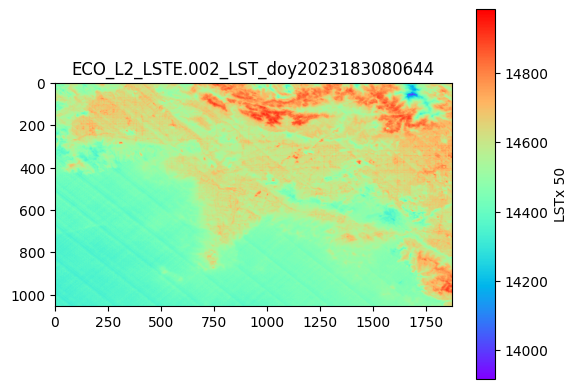

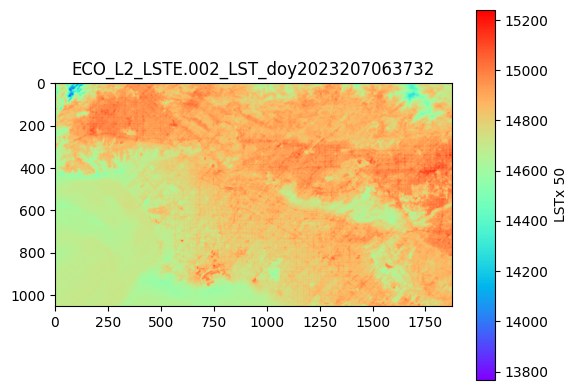

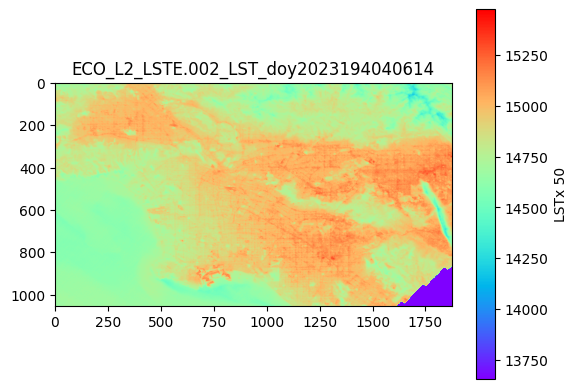

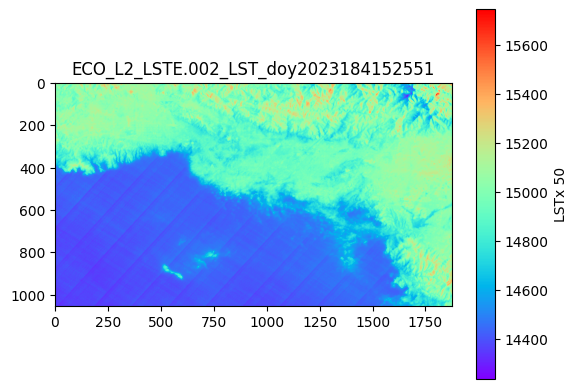

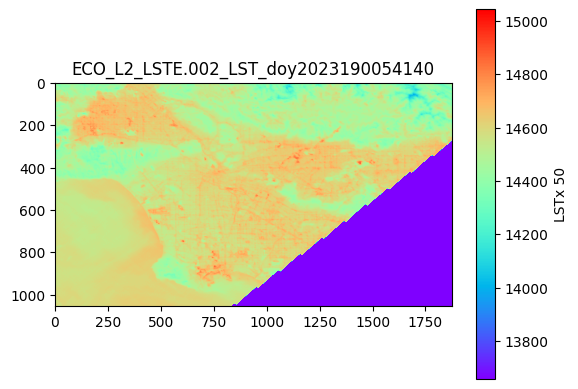

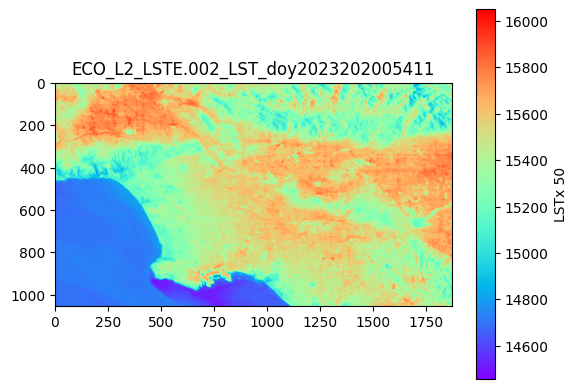

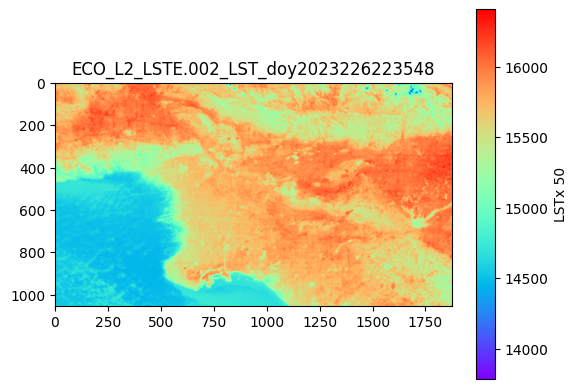

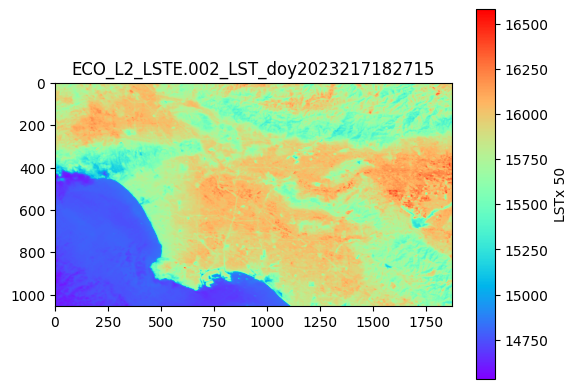

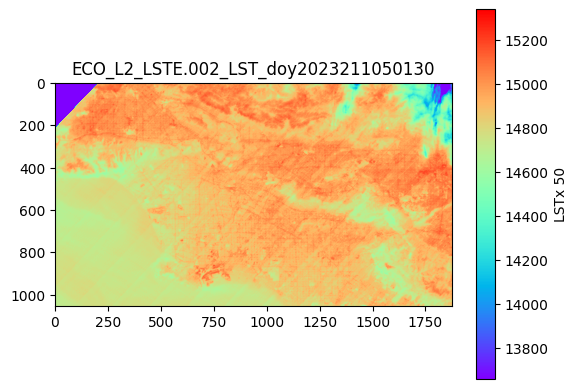

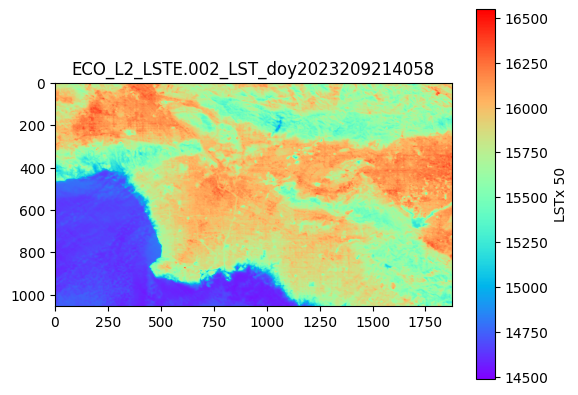

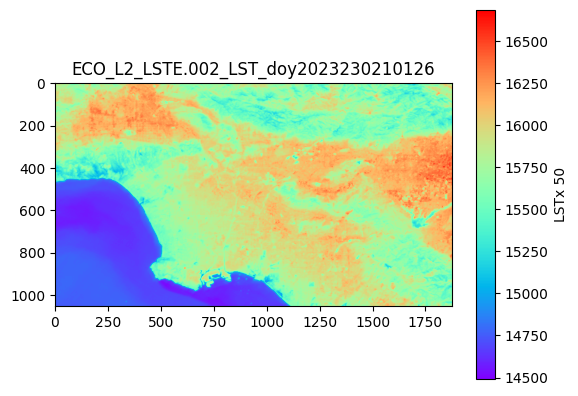

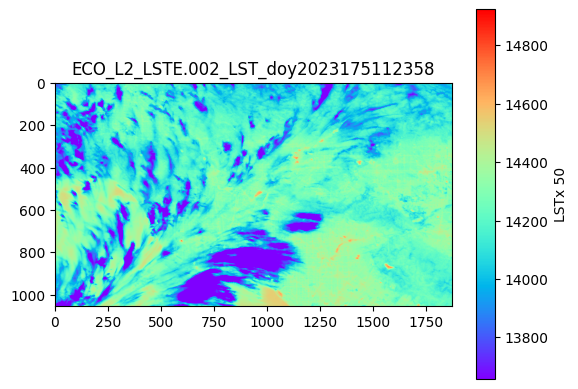

In [23]:
for filename in os.listdir(LST_folder):
  if filename.endswith('.tif'):
    img_path = os.path.join(LST_folder, filename)
    lst_img = mpimg.imread(img_path)
    img_min = lst_img.min()

    vmin = max(img_min, 273.15*50) # to be able to distinguish anything on images with NaNs, we'll ensure that the minimum of the scale is 0°C

    plt.figure()
    plt.imshow(lst_img, cmap='rainbow',vmin = vmin)
    plt.colorbar(label='LSTx 50')
    plt.title(filename[:-12])
    plt.show()

Some images are usable as is, some need to be discarded because the overpass is too small compared to the observed area, there could also be scenes too cloudy or too badly geolocated.

### Masking and conversion to Celcius

In [18]:
# If less than threshold  of the extent is of good quality then we'll discard the scene
threshold = 0.75  # the limit chosen for the matching overpass (0-1)

# Create a folder for the discarded files
discarded_folder = 'LA_2023_07_08/discarded'
if not os.path.exists(discarded_folder):
  os.mkdir(discarded_folder)

# Create a folder for the masked files
masked_folder = 'LA_2023_07_08/LST_masked'
if not os.path.exists(masked_folder):
  os.mkdir(masked_folder)

for file in os.listdir(QC_folder) :
    qc_file_path = os.path.join(QC_folder,file)
    lst_file_path = qc_file_path.replace('QC','LST')
    cld_file_path = qc_file_path.replace('QC','cloud_mask')
    if os.path.exists(lst_file_path) and os.path.exists(cld_file_path): # AppEEARS may provide more QC than LST or cloud_masks files, so we add this safeguard
      with rasterio.open(qc_file_path) as qc_f :  
        qc_img = qc_f.read(1)
        qc_img[qc_img==-99999] = -1
        granule_size = qc_img.size
        qc_img_2 = qc_img & 0b11 # The last two bits contain all the information needed to assess the quality of a pixel
        qc_msk = np.where(qc_img_2>1,np.nan,1) # This array is a mask where bad quality pixels are NaNs
        
      with rasterio.open(lst_file_path) as lst_f : 
        lst_img = lst_f.read(1)
        lst_img_msk = lst_img*qc_msk # Apply the qc mask

        out_meta = lst_f.meta.copy()
        out_meta.update({'nodata':np.nan,"dtype":'float32'})
          
    # In collection 2 the QC cloud bit is unreliable, we have to use the cloud mask too 
      
      with rasterio.open(cld_file_path) as cld_f : 
        cld_img = cld_f.read(1)
        cld_msk = np.where(cld_img==0,1,np.nan) # This array is also a mask where clouds are nans, and clear pixels are 1
      lst_img_msk=lst_img_msk*cld_msk
      
      # Scale the image to Celcius
      lst_img_msk = lst_img_msk/50 +0.49 # scale the image to Kelvin (cf UserGuide, the image is scaled at 0.02)
      lst_img_msk = lst_img_msk - 273.15 # Kelvin to Celcius
      # lst_img_msk = lst_img_msk * 1.8 + 32 # Celcius to Farenheit

      # If the image is sufficently clear, we'll mask it and use it later, if it is too cloudy, we'll discard it
      if np.count_nonzero(np.isnan(lst_img_msk))< (1-threshold)*granule_size : 
        
        lst_masked_file_path = os.path.join(LST_masked_folder,file.replace('QC','LST_masked'))        
        with rasterio.open(lst_masked_file_path,'w',**out_meta) as dst : 
          dst.write(lst_img_msk,1)
      else : 
        os.rename(lst_file_path,lst_file_path.replace(LST_folder,discarded_folder))

Display the images left after the masking

In [16]:
# Function to generate a proper title from the file name
def title_from_file(filename):
  time_info = filename.split('_')[5][3:]
  dt = datetime.strptime(time_info, '%Y%j%H%M%S')
  local_dt = dt - timedelta(hours=7)
  formatted_datetime = local_dt.strftime('%Y-%m-%d at %I:%M %p (PST)')
  title = f"LST(K) over LA Area, {formatted_datetime} "

  return title

In [ ]:
for filename in os.listdir(LST_masked_folder):
    if filename.endswith('.tif'):
        lst_file_path = os.path.join(LST_masked_folder, filename)
        with rasterio.open(lst_file_path) as src:
            lst_img = src.read(1)  
            vmin = np.nanmin(lst_img)
            if np.isnan(vmin) : 
                vmin =  0

        # Create a custom colormap
        custom_cmap = plt.get_cmap('rainbow')
        custom_cmap.set_bad('black')
        custom_cmap.set_over('black')  # Set color for values below vmin to black : water, clouds and non defined pixels


       
        plt.figure()
        plt.imshow(lst_img, cmap=custom_cmap, vmin=vmin)
        plt.colorbar(label='Land Surface temperature (C)')
        plt.title(title_from_file(filename))
        plt.show()


### Water masking

In [20]:
for file in os.listdir(LST_masked_folder):
    if file.endswith('.tif') and not file.__contains__('water'):
        lst_file_path = os.path.join(LST_masked_folder,file)
        water_mask_path = os.path.join(water_mask_folder,file.replace('_LST_masked','_water_mask'))
        
        with rasterio.open(water_mask_path) as water_msk_f :
            water_img = water_msk_f.read(1)
            water_mask = np.where(water_img == 0,1, np.nan) # water mask : 1 for land, NaN for water
        
        with rasterio.open(lst_file_path) as lst_f : 
            lst_img = lst_f.read(1)
            lst_water_masked = lst_img*water_mask
            out_meta = lst_f.meta.copy()
            
        lst_water_masked_path = lst_file_path.replace('_LST_masked','_LST_watermasked')
        
        with rasterio.open(lst_water_masked_path,'w',**out_meta) as dst :
            dst.write(lst_water_masked,1)
        

Display the water masked granules

In [ ]:
for filename in os.listdir(LST_masked_folder):
  if filename.endswith('.tif') and filename.__contains__('watermasked'):
        lst_file_path = os.path.join(LST_masked_folder, filename)
        with rasterio.open(lst_file_path) as src:
            lst_img = src.read(1)  
            vmin = np.nanmin(lst_img)
            if np.isnan(vmin) : 
                vmin =  0

        # Create a custom colormap
        custom_cmap = plt.get_cmap('rainbow')
        custom_cmap.set_bad('black')
        custom_cmap.set_over('black')  # Set color for values below vmin to black : water, clouds and non defined pixels


        
        plt.figure()
        plt.imshow(lst_img, cmap=custom_cmap, vmin=vmin)
        plt.colorbar(label='Land Surface temperature (C)')
        plt.title(title_from_file(filename))
        plt.show()


### Animation

Create a short video of all the selected and masked scenes, to illustrate the heatwave. 

In [ ]:
rc('animation', html='jshtml')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axis_off()

div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

LST_masked_rasters = [rxr.open_rasterio(os.path.join(LST_masked_folder,filename)).squeeze("band", drop=True) for filename in os.listdir(LST_masked_folder) if filename.endswith('tif')and filename.__contains__('watermasked')]
custom_cmap = plt.colormaps['rainbow'].copy()
custom_cmap.set_under('black')
custom_cmap.set_bad('black')

frames = []
for i in range(len(LST_masked_rasters)):
  LST_data = LST_masked_rasters[i].values
  lst_min = LST_data.min()
  np.nan_to_num(LST_data,copy = False)
  frames.append(LST_data)

cv0 = frames[0]
im = ax.imshow(cv0,cmap=custom_cmap)
cb = fig.colorbar(im, cax=cax)
tx = ax.set_title(title_from_file(os.listdir(LST_masked_folder)[i]))

def animate(i):
  arr = frames[i]
  vmax     = np.max(arr[arr>0.0])
  vmin     = np.min(arr[arr>0.0])
  im.set_data(arr)
  im.set_clim(vmin, vmax)
  tx.set_text(title_from_file(os.listdir(LST_masked_folder)[i]))
  return im,tx


ani = animation.FuncAnimation(fig, animate, frames=len(LST_masked_rasters),interval=1000,blit = True, repeat_delay=5000)
ani.save(filename="LA_09_2024/time_series.gif", writer="pillow")
ani